# Structure from Motion

Numpy와 OpenCV-Python을 활용하여 Structure from Motion algorithm을 구현해봅시다.

## Table of Contents

- Load images
- Extract and match features (Exercise 1)
- Camera pose estimatation and triangulation
    - Estimate essential matrix (Exercise 2)
    - Decompose E to RT (Exercise 3)
    - Triangulation (Exercise 4)
- Visualization (Optional)

## Reference
https://woochan-autobiography.tistory.com/950#2.%20Load%20input%20images
https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga0b166d41926a7793ab1c351dbaa9ffd4

## 1. Load images

OpenCV-Python을 설치하고, 필요한 package들을 import한다.
이때 opencv의 namespace는 cv2인데, cv2를 그대로 사용해도 되고, 아래와 같이 cv로 변환하여 사용해도 된다.
Reference의 코드를 활용할때 주의해야 한다.

In [1]:
# opencv 설치 (최초 한번만 실행)
!pip install opencv-python  

     ---------------------------------------- 38.6/38.6 MB 8.4 MB/s eta 0:00:00


<function matplotlib.pyplot.show(close=None, block=None)>

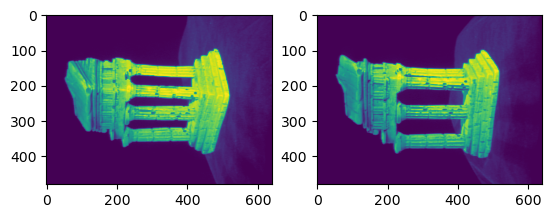

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

filename1 = 'templeSR0015.png'
filename2 = 'templeSR0016.png'

img1 = cv.imread(filename1,cv.IMREAD_GRAYSCALE) # grayscale
img2 = cv.imread(filename2,cv.IMREAD_GRAYSCALE)
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show

## 2. Extract and match features

이미지로부터 특징점들을 추출해 서로 matching하여 대응점을 찾는다.
이때 SIFT feature를 활용하여 keypoint와 descriptor를 얻는다.
keypoint는 이미지에서 feature의 위치좌표(x,y)이며, descriptor는 해당 feature를 표현한 vector이다.

### Exercise 1 [2점]
Reference 코드를 참고하여 각 이미지에서 SIFT를 추출하시오 matching하여 대응점을 찾아 visualize하는 부분은 아래 구현되어 있음.

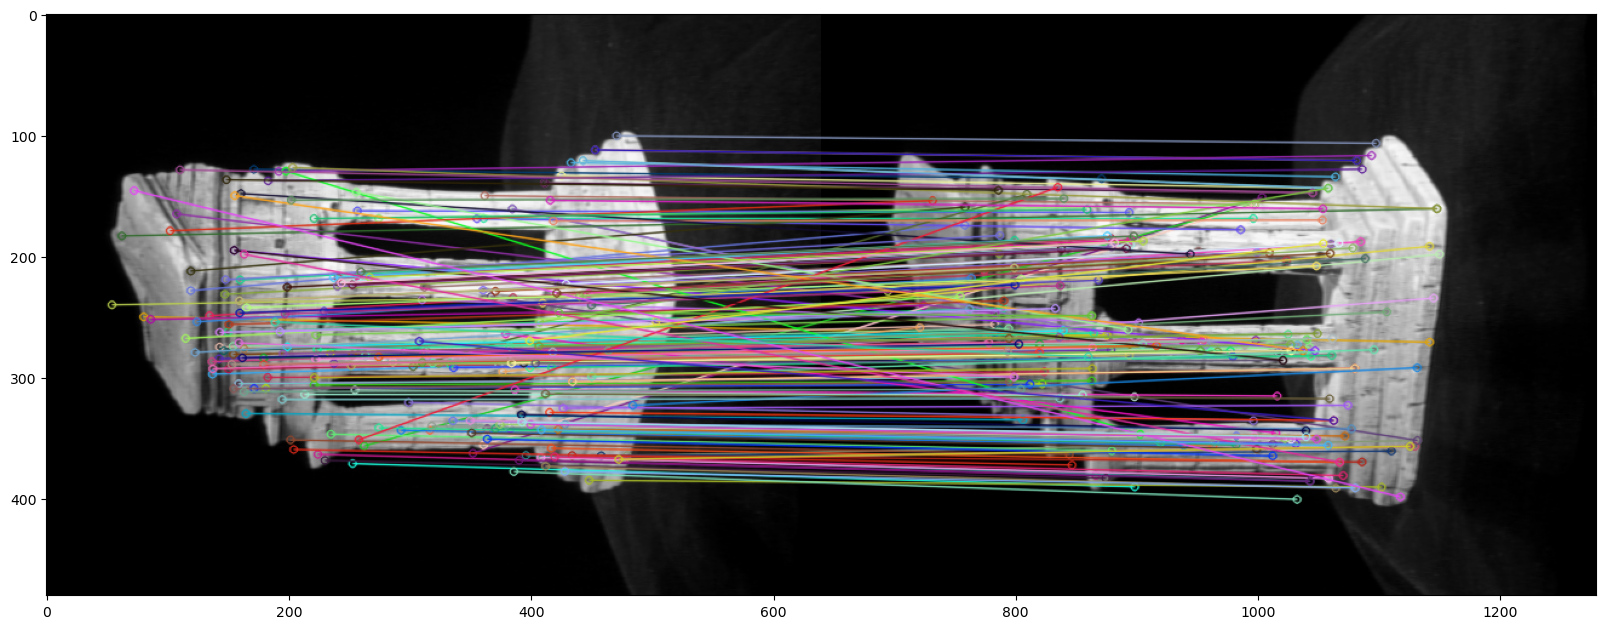

In [3]:
sift = cv.SIFT_create()
# Exercise 1
# Find the keypoints and descriptors with SIFT for each image
# (~ 2 lines of code)
# kp1, des1 = ...
# kp2, des2 = ...
# YOUR CODE STARTS HERE
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# YOUR CODE ENDS HERE

# Brute force matching with k=2
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Ratio test and retrieval of indices
matches_good = [m1 for m1, m2 in matches if m1.distance < 0.80*m2.distance]

sorted_matches = sorted(matches_good, key=lambda x: x.distance)
res = cv.drawMatches(img1, kp1, img2, kp2, sorted_matches, img2, flags=2) 

plt.figure(figsize=(20, 20))
plt.imshow(res)
plt.show()

SIFT로 매칭된 결과는 아래와 같이 시각화된다.

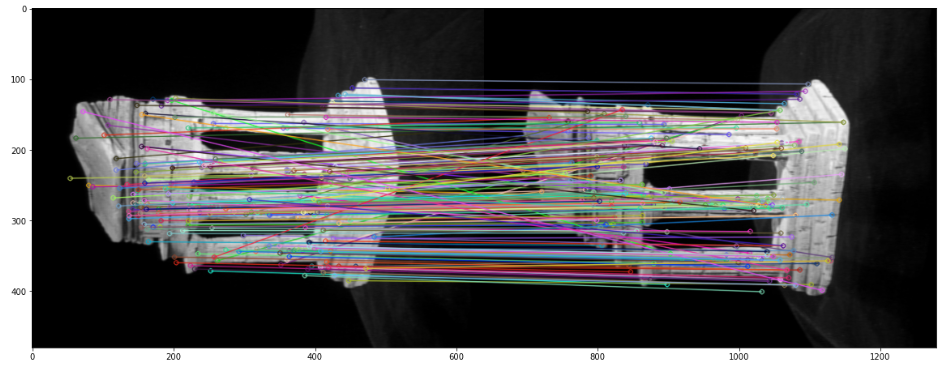

## 3. Camera pose estimation and triangulation

이 섹션은 아래와 같이 세 부분으로 이루어진다.

### 3.1 Estimate essential matrix E (Exercise 2) [2점]

현재 매칭된 점(x1, x2)들은 SIFT의 descriptor vector 비교만으로 뽑은 매칭점들이라, 위의 그림에서 보이는 것처럼 잘못된 매칭점들이 많다. 이들을 활용하여 Essential matrix E를 추정하고, 추정된 E에 잘 맞는 매칭점들만 다시 inlier로 추려낼 것이다. 이는 RANSAC 기반의 Essential matrix 추정법이다. OpenCV의 `cv.findEssentialMat` 함수를 활용하고, x1, x2와 함께 아래 코드에 정의된 camera matrix K를 입력 파라미터로 넣으시오.

### 3.2 Decompose E to RT (Exercise 3) [2점]

Essential matrix E로부터 camera pose RT를 추정할 수 있다. 이때의 RT는 첫번째 카메라의 pose를 $[I|0]$로 정의했을 때 두번째 카메라의 상대적인 pose를 뜻한다. Essential matrix E로부터 decompose되는 RT는 4가지인데, 추정된 RT로부터 3D point들을 triangulation 했을 때 물리적으로 가능한 구성은 1가지 뿐이다. OpenCV의 `cv.recoverPose` 함수를 활용하면 E와 함께 x1, x2, K를 입력받아 물리적으로 가능한 RT 한쌍만을 반환해준다. 이때, x1, x2는 Essential matrix를 구했을 때 추려낸 inlier들만 활용하도록 주의한다.

### 3.3 Triangulation (Exercise 4) [4점]

위의 단계에서 구한 R과 T를 가로로 stack하여 3x4 pose matrix를 구성한다. 이렇게 구성한 pose matrix의 왼쪽에 camera matrix K를 곱하면 두번째 카메라의 projection matrix M2를 구할 수 있다. 첫번째 카메라의 projection matrix M1은 $[I|0]$의 왼쪽에 동일한 camera matrix K에 곱한다. 이는 matrix multiplication이므로 Numpy의 `np.matmul` 함수를 활용한다.
2차원 대응점과 함께 camera projection matrix들이 구해졌으므로 이들을 활용하여 3D point들을 triangulation 할수 있다. 이는 OpenCV의 `cv.triangulatePoints` 함수를 활용한다. 이 함수는 M1, M2, x1, x2들을 입력받아 3차원 point들을 반환한다. 이때, x1, x2는 Essential matrix를 구했을 때 추려낸 inlier들만 활용하되, 이들을 transpose하여 $(2 \times n)$ 형태로 입력하도록 주의한다 (`np.transpose` 활용). 반환되는 3차원 point는 $(4 \times n)$ 형태의 homogeneous coordinate이므로, 4번째 차원의 값으로 나머지 차원을 나눠주어야 최종적인 Euclidean coordinate X,Y,Z 좌표값을 얻을 수 있다. 

In [6]:
# queryIdx : 1번 이미지의 feature point index
# trainIdx : 2번 이미지의 feature point index
query_idx = [match.queryIdx for match in matches_good]
train_idx = [match.trainIdx for match in matches_good]

#Getting float based points from good matches
x1 = np.float32([kp1[ind].pt for ind in query_idx])
x2 = np.float32([kp2[ind].pt for ind in train_idx])

K = np.array([[1520.4, 0.0, 302.32], [0.0, 1525.9, 246.87], [0.0, 0.0, 1.0]])  # Camera matrix K

# Exercise 2 [1 pt]
# Estimate essential matrix E
# (~ 1 line of code)
# E, mask = ...
# YOUR CODE STARTS HERE
E, mask = cv.findEssentialMat(x1, x2, K)
# YOUR CODE ENDS HERE

x1_in = x1[np.squeeze(mask==1),:]  # inliers of x1
x2_in = x2[np.squeeze(mask==1),:]  # inliers of x2

# Exercise 3
# Decompose E to RT
# (~ 1 line of code)
# retval, R, t, _ = ...
# YOUR CODE STARTS HERE
retval, R, t, _ = cv.recoverPose(E, x1_in, x2_in, K)
# YOUR CODE ENDS HERE

Rt1 = np.hstack((np.eye(3), np.zeros((3,1))))  # [R|t]=[I|0] for camera 1
Rt2 = np.hstack((R,t))                         # [R|t] for camera 2

# Exercise 4
# Triangulation
# (~ 6 line of code)
# M1 = ...                  # projection matrix for camera 1
# M2 = ...                  # projection matrix for camera 2
# x1_in_transpose = ...     # transpose inlier points to (2xn) shape
# x2_in_transpose = ...     # transpose inlier points to (2xn) shape
# point3d = ...             # triangulation
# point3d /= point3d[3,:]   # homogeneous to euclidean
# YOUR CODE STARTS HERE
M1 = np.matmul(K, Rt1)
M2 = np.matmul(K, Rt2)
x1_in_transpose = np.transpose(x1_in)
x2_in_transpose = np.transpose(x2_in)
point3d = cv.triangulatePoints(M1, M2, x1_in_transpose, x2_in_transpose)
point3d /= point3d[3, :]
# YOUR CODE ENDS HERE

## 4. Visualization (optional)

Triangulation된 3D point들은 아래와 같이 시각화한다. 현재 아래의 코드는 3D를 하나의 시점에서만 관측하여 그려주는 plot인데, 이를 interactive하게 관측할수 있으면 더욱 자세히 3차원을 볼수 있다. plotly 등의 library를 활용하여 아래 코드를 interactive plot으로 수정하시오. (Optional) 

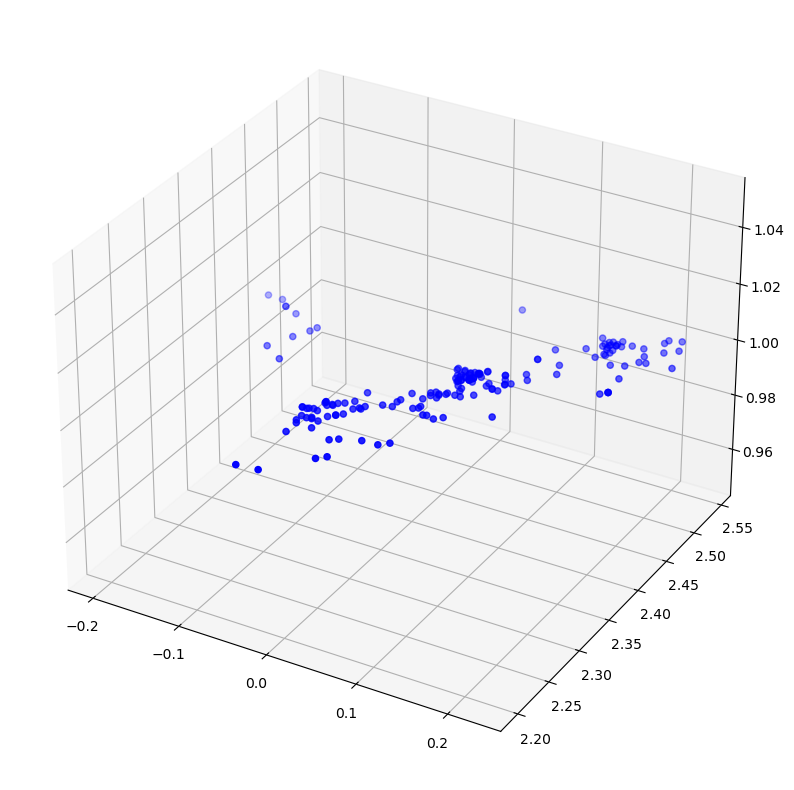

In [7]:
X = np.array(point3d[1,:])
Y = np.array(point3d[2,:])
Z = np.array(point3d[3,:])
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, c='b', marker='o')
plt.show()

시각화코드를 수정하지 않고 그대로 실행하면 아래와 같은 결과를 얻을 수 있다.
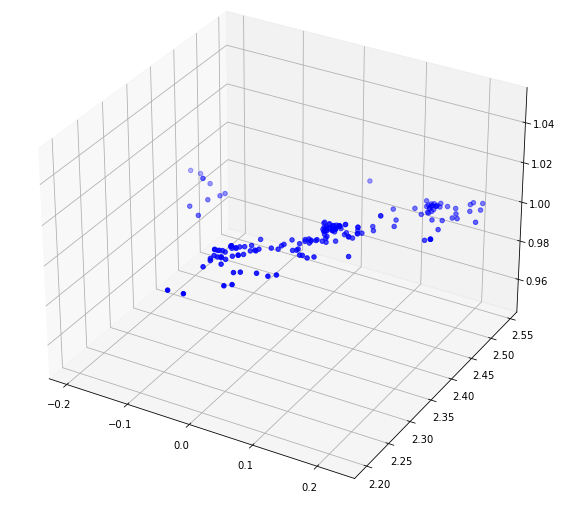